In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/samyakjain2052/new-data/combine_data_final.csv
/kaggle/input/d/samyakjain2052/new-data/test_data.csv
/kaggle/input/d/samyakjain2052/dataset/combine_data_final.csv
/kaggle/input/d/samyakjain2052/dataset/test_data.csv
/kaggle/input/final-data/train_data.csv
/kaggle/input/final-data/test_data.csv


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from functools import partial

In [3]:
df = pd.read_csv("/kaggle/input/d/samyakjain2052/new-data/combine_data_final.csv")

In [4]:
df.head()

,UID,Target,Feature_5,Feature_16,Feature_10,Feature_11,Feature_13,Feature_9,Feature_15,Feature_6,Feature_1
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,2,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,2,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,1,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.isnull().sum()

UID              0
Target           0
Feature_5        0
Feature_16       0
Feature_10     494
Feature_11       0
Feature_13       0
Feature_9        0
Feature_15       0
Feature_6     1927
Feature_1        6
dtype: int64

In [6]:
# Check missing values
df.isnull().sum()

UID              0
Target           0
Feature_5        0
Feature_16       0
Feature_10     494
Feature_11       0
Feature_13       0
Feature_9        0
Feature_15       0
Feature_6     1927
Feature_1        6
dtype: int64

In [7]:
# Summary statistics for numerical columns
df.describe()

,UID,Target,Feature_5,Feature_16,Feature_10,Feature_11,Feature_13,Feature_15
count,2494.000000,2494.000000,2494.000000,2494.000000,2000.00000,2494.000000,2494.000000,2494.000000
mean,674.816359,0.381716,2.314755,1.389735,29.64184,0.481957,0.430634,32.313283
std,436.401260,0.485905,0.832531,0.487788,14.51196,1.025290,0.929850,50.333678
min,1.000000,0.000000,1.000000,1.000000,0.42000,0.000000,0.000000,0.000000
25%,312.250000,0.000000,2.000000,1.000000,20.37500,0.000000,0.000000,7.925000
50%,624.000000,0.000000,3.000000,1.000000,28.00000,0.000000,0.000000,14.454200
75%,979.750000,1.000000,3.000000,2.000000,38.00000,1.000000,1.000000,31.000000
max,1603.000000,1.000000,3.000000,2.000000,80.00000,8.000000,8.000000,512.329200


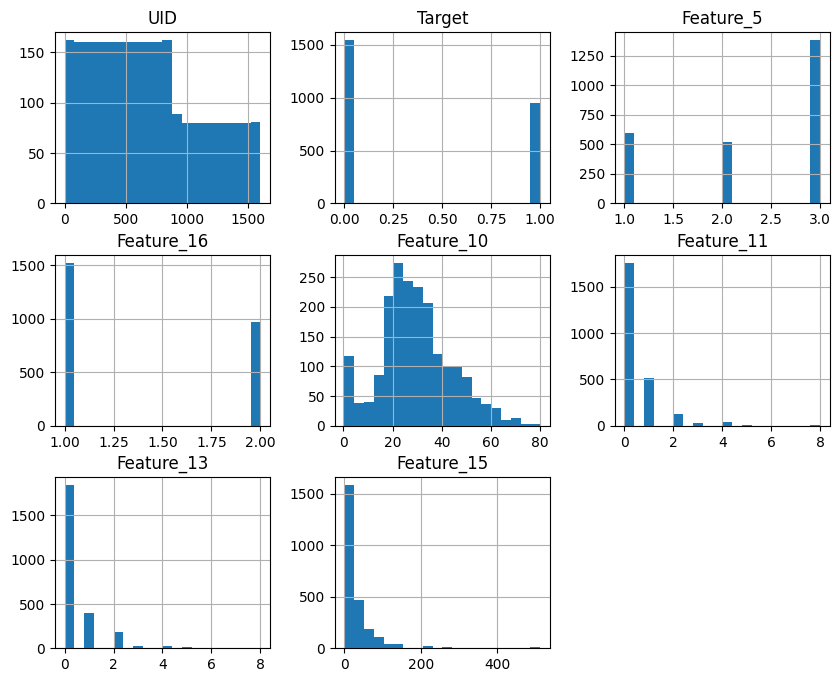

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions
df.hist(figsize=(10, 8), bins=20)
plt.show()


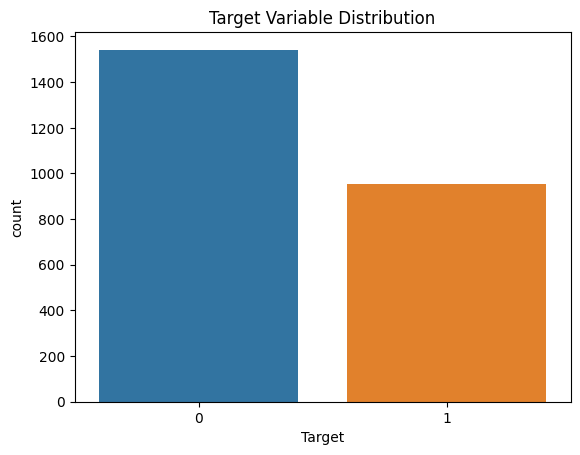

In [9]:
# Count of Target variable
sns.countplot(x=df["Target"])
plt.title("Target Variable Distribution")
plt.show()


In [10]:
# Unique values in categorical features
df[['Feature_9', 'Feature_1']].nunique()


Feature_9    681
Feature_1      3
dtype: int64

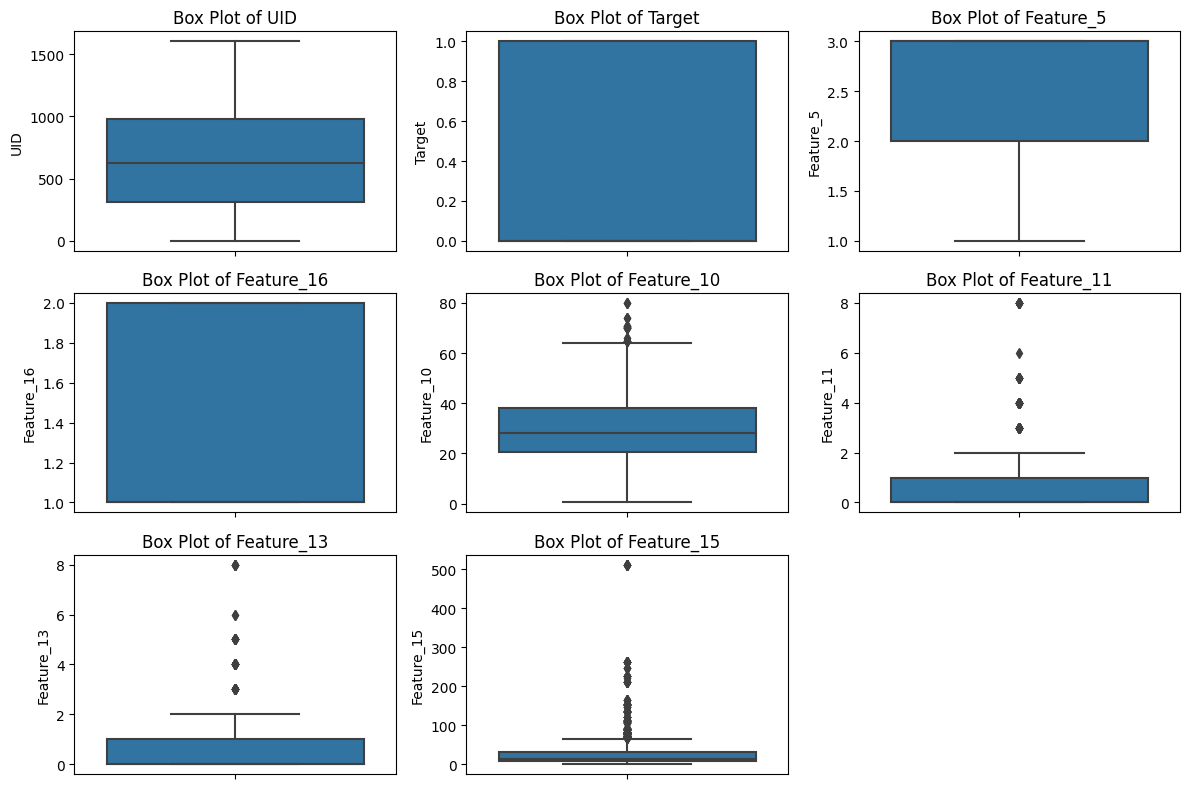

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns only
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Create box plots for each numerical column
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)  # Adjust rows & cols as per dataset
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.tight_layout()

plt.show()


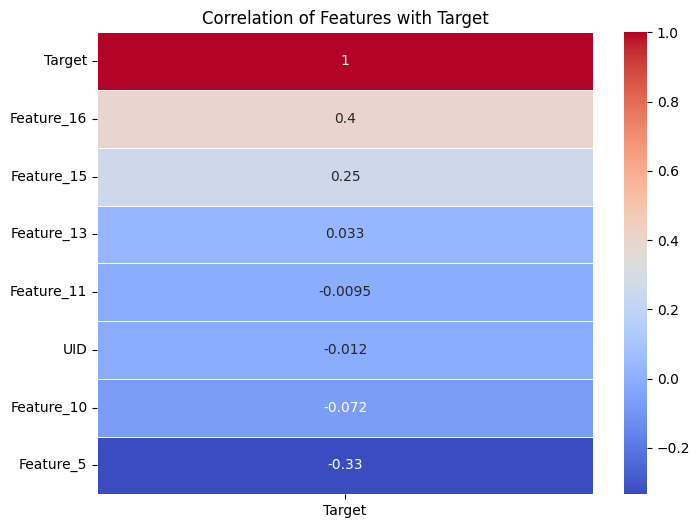

In [12]:

# Compute correlation of numerical columns with the Target column
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[num_cols].corr()

# Extract correlation of each feature with Target
target_correlation = correlation_matrix["Target"].sort_values(ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(target_correlation.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation of Features with Target")
plt.show()


In [13]:
def preprocess(df, scaler=None, is_training=True):
    """Enhanced preprocessing with better feature engineering and scaling"""
    df = df.copy()

    # Basic imputation with more sophisticated grouping
    df['Feature_10'] = df['Feature_10'].fillna(df.groupby(['Feature_5', 'Feature_16'])['Feature_10'].transform('median'))
    df['Feature_15'] = df['Feature_15'].fillna(df.groupby(['Feature_5', 'Feature_1'])['Feature_15'].transform('median'))
    df['Feature_1'] = df['Feature_1'].fillna(df['Feature_1'].mode()[0])

    # Feature engineering
    df['Feature_17'] = (~df['Feature_6'].isna()).astype(int)
    df['Feature_18'] = df['Feature_11'] + df['Feature_13'] + 1
    df['Feature_19'] = (df['Feature_18'] == 1).astype(int)

    # Fixed binning for FamilySize
    df['Feature_20'] = pd.cut(df['Feature_18'], 
                              bins=[0, 1, 2, 4, float('inf')],
                              labels=['Single', 'Small', 'Medium', 'Large'],
                              include_lowest=True)

    # Handle fare binning
    try:
        df['Feature_21'] = pd.qcut(df['Feature_15'], 
                               q=5, 
                               labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])
    except ValueError:
        fare_bins = [0, df['Feature_15'].quantile(0.2), df['Feature_15'].quantile(0.4),
                    df['Feature_15'].quantile(0.6), df['Feature_15'].quantile(0.8), float('inf')]
        df['Feature_21'] = pd.cut(df['Feature_15'], 
                              bins=fare_bins,
                              labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'],
                              include_lowest=True)

    # Handle age binning
    try:
        df['Feature_22'] = pd.qcut(df['Feature_10'],
                              q=5,
                              labels=['Very_Young', 'Young', 'Middle', 'Mature', 'Senior'])
    except ValueError:
        age_bins = [0, 16, 32, 48, 64, float('inf')]
        df['Feature_22'] = pd.cut(df['Feature_10'],
                             bins=age_bins,
                             labels=['Very_Young', 'Young', 'Middle', 'Mature', 'Senior'],
                             include_lowest=True)

    # Create numerical features
    df['Feature_23'] = df['Feature_15'] / df['Feature_18']
    df['Feature_24'] = df['Feature_10'] / (df['Feature_15'] + 1)  # Avoid division by zero

    # Scale numerical features
    numerical_features = ['Feature_10', 'Feature_15', 'Feature_23', 'Feature_24']
    if is_training:
        scaler = StandardScaler()
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
    elif scaler is not None:
        df[numerical_features] = scaler.transform(df[numerical_features])

    # Drop unnecessary columns
    columns_to_drop = ['Feature_6', 'Feature_12', 'Feature_9']
    df = df.drop([col for col in columns_to_drop if col in df.columns], axis=1)

    return df, scaler


In [14]:
def create_model(trial, input_features):
    """Create model with hyperparameters suggested by optuna"""
    return tfdf.keras.GradientBoostedTreesModel(
        verbose=0,
        features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
        exclude_non_specified_features=True,
        min_examples=trial.suggest_int('min_examples', 5, 20),
        categorical_algorithm=trial.suggest_categorical('categorical_algorithm', ['CART', 'RANDOM']),
        num_trees=trial.suggest_int('num_trees', 200, 500),
        shrinkage=trial.suggest_float('shrinkage', 0.01, 0.3, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 8),
        validation_ratio=0.2,
        random_seed=42
    )


In [15]:
def objective(trial, train_df, input_features):
    """Objective function for optuna optimization"""
    n_folds = 5
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(train_df, train_df['Target']):
        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_fold, label="Target")
        val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_fold, label="Target")

        model = create_model(trial, input_features)
        model.fit(train_ds)

        val_pred = model.predict(val_ds)
        val_pred_classes = (val_pred[:, 0] >= 0.5).astype(int)
        val_true = val_fold['Target'].values

        accuracy = accuracy_score(val_true, val_pred_classes)
        auc = roc_auc_score(val_true, val_pred[:, 0])
        scores.append((accuracy + auc) / 2)

    return np.mean(scores)


In [16]:
# Load data
train_df = pd.read_csv("/kaggle/input/d/samyakjain2052/new-data/combine_data_final.csv")
serving_df = pd.read_csv("/kaggle/input/d/samyakjain2052/new-data/test_data.csv")

# Preprocess training data
preprocessed_train_df, scaler = preprocess(train_df, is_training=True)

# Define feature set
input_features = [
    'Feature_5', 'Feature_16', 'Feature_10', 'Feature_11', 'Feature_13', 'Feature_15', 'Feature_1',
    'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20',
    'Feature_23', 'Feature_21', 'Feature_22', 'Feature_24'
]

# Run hyperparameter optimization
study = optuna.create_study(direction='maximize')
objective_with_params = partial(objective, train_df=preprocessed_train_df, input_features=input_features)
study.optimize(objective_with_params, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)


[I 2025-02-04 13:48:56,090] A new study created in memory with name: no-name-7de49427-fb4a-4bb9-8dac-50eb676b9eab


1/1 [==============================] - 0s 64ms/step


[I 2025-02-04 13:49:11,842] Trial 0 finished with value: 0.9230773954576892 and parameters: {'min_examples': 11, 'categorical_algorithm': 'CART', 'num_trees': 472, 'shrinkage': 0.17869531569224154, 'max_depth': 8}. Best is trial 0 with value: 0.9230773954576892.


1/1 [==============================] - 0s 67ms/step


[I 2025-02-04 13:49:29,376] Trial 1 finished with value: 0.9240862494297326 and parameters: {'min_examples': 6, 'categorical_algorithm': 'CART', 'num_trees': 308, 'shrinkage': 0.06275961749500962, 'max_depth': 8}. Best is trial 1 with value: 0.9240862494297326.


1/1 [==============================] - 0s 65ms/step


[I 2025-02-04 13:49:38,146] Trial 2 finished with value: 0.859231523145146 and parameters: {'min_examples': 19, 'categorical_algorithm': 'CART', 'num_trees': 329, 'shrinkage': 0.02501989694849737, 'max_depth': 5}. Best is trial 1 with value: 0.9240862494297326.


1/1 [==============================] - 0s 69ms/step


[I 2025-02-04 13:49:45,233] Trial 3 finished with value: 0.9109187911158779 and parameters: {'min_examples': 10, 'categorical_algorithm': 'RANDOM', 'num_trees': 353, 'shrinkage': 0.11819563042258259, 'max_depth': 4}. Best is trial 1 with value: 0.9240862494297326.


1/1 [==============================] - 0s 64ms/step


[I 2025-02-04 13:49:57,678] Trial 4 finished with value: 0.8902899571292181 and parameters: {'min_examples': 19, 'categorical_algorithm': 'RANDOM', 'num_trees': 286, 'shrinkage': 0.03285423100283208, 'max_depth': 7}. Best is trial 1 with value: 0.9240862494297326.


1/1 [==============================] - 0s 65ms/step


[I 2025-02-04 13:50:08,831] Trial 5 finished with value: 0.9264010604302504 and parameters: {'min_examples': 12, 'categorical_algorithm': 'RANDOM', 'num_trees': 482, 'shrinkage': 0.14109697626488693, 'max_depth': 8}. Best is trial 5 with value: 0.9264010604302504.


1/1 [==============================] - 0s 66ms/step


[I 2025-02-04 13:50:19,646] Trial 6 finished with value: 0.8492538257395417 and parameters: {'min_examples': 12, 'categorical_algorithm': 'CART', 'num_trees': 249, 'shrinkage': 0.011666554827524272, 'max_depth': 6}. Best is trial 5 with value: 0.9264010604302504.


1/1 [==============================] - 0s 63ms/step


[I 2025-02-04 13:50:26,072] Trial 7 finished with value: 0.8346609192251229 and parameters: {'min_examples': 8, 'categorical_algorithm': 'CART', 'num_trees': 299, 'shrinkage': 0.015273815815048249, 'max_depth': 4}. Best is trial 5 with value: 0.9264010604302504.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:50:33,713] Trial 8 finished with value: 0.8614752973295514 and parameters: {'min_examples': 5, 'categorical_algorithm': 'CART', 'num_trees': 255, 'shrinkage': 0.021781388391758444, 'max_depth': 5}. Best is trial 5 with value: 0.9264010604302504.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:50:38,811] Trial 9 finished with value: 0.8736343615745433 and parameters: {'min_examples': 12, 'categorical_algorithm': 'CART', 'num_trees': 275, 'shrinkage': 0.14016256303874539, 'max_depth': 3}. Best is trial 5 with value: 0.9264010604302504.


1/1 [==============================] - 0s 63ms/step


[I 2025-02-04 13:50:47,018] Trial 10 finished with value: 0.9269054291740672 and parameters: {'min_examples': 16, 'categorical_algorithm': 'RANDOM', 'num_trees': 490, 'shrinkage': 0.2891236603225962, 'max_depth': 7}. Best is trial 10 with value: 0.9269054291740672.


1/1 [==============================] - 0s 87ms/step


[I 2025-02-04 13:50:55,501] Trial 11 finished with value: 0.9261981299011823 and parameters: {'min_examples': 16, 'categorical_algorithm': 'RANDOM', 'num_trees': 497, 'shrinkage': 0.2965378358545961, 'max_depth': 7}. Best is trial 10 with value: 0.9269054291740672.


1/1 [==============================] - 0s 65ms/step


[I 2025-02-04 13:51:04,068] Trial 12 finished with value: 0.9290782387125265 and parameters: {'min_examples': 15, 'categorical_algorithm': 'RANDOM', 'num_trees': 427, 'shrinkage': 0.29429915239938403, 'max_depth': 7}. Best is trial 12 with value: 0.9290782387125265.


1/1 [==============================] - 0s 63ms/step


[I 2025-02-04 13:51:12,091] Trial 13 finished with value: 0.9279497864331369 and parameters: {'min_examples': 15, 'categorical_algorithm': 'RANDOM', 'num_trees': 421, 'shrinkage': 0.2891866690195421, 'max_depth': 7}. Best is trial 12 with value: 0.9290782387125265.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:51:23,671] Trial 14 finished with value: 0.9248534669270709 and parameters: {'min_examples': 16, 'categorical_algorithm': 'RANDOM', 'num_trees': 410, 'shrinkage': 0.08561819543070066, 'max_depth': 6}. Best is trial 12 with value: 0.9290782387125265.


1/1 [==============================] - 0s 61ms/step


[I 2025-02-04 13:51:32,796] Trial 15 finished with value: 0.9279129253900417 and parameters: {'min_examples': 14, 'categorical_algorithm': 'RANDOM', 'num_trees': 412, 'shrinkage': 0.20823809963088893, 'max_depth': 7}. Best is trial 12 with value: 0.9290782387125265.


1/1 [==============================] - 0s 66ms/step


[I 2025-02-04 13:51:45,087] Trial 16 finished with value: 0.915009244888845 and parameters: {'min_examples': 14, 'categorical_algorithm': 'RANDOM', 'num_trees': 403, 'shrinkage': 0.05163599339923828, 'max_depth': 6}. Best is trial 12 with value: 0.9290782387125265.


1/1 [==============================] - 0s 86ms/step


[I 2025-02-04 13:51:55,477] Trial 17 finished with value: 0.9142037732692678 and parameters: {'min_examples': 17, 'categorical_algorithm': 'RANDOM', 'num_trees': 208, 'shrinkage': 0.0919083826109694, 'max_depth': 7}. Best is trial 12 with value: 0.9290782387125265.


1/1 [==============================] - 0s 65ms/step


[I 2025-02-04 13:52:04,812] Trial 18 finished with value: 0.9276593305886387 and parameters: {'min_examples': 14, 'categorical_algorithm': 'RANDOM', 'num_trees': 372, 'shrinkage': 0.21390088289073914, 'max_depth': 8}. Best is trial 12 with value: 0.9290782387125265.


1/1 [==============================] - 0s 66ms/step


[I 2025-02-04 13:52:17,207] Trial 19 finished with value: 0.9091982193322758 and parameters: {'min_examples': 20, 'categorical_algorithm': 'RANDOM', 'num_trees': 435, 'shrinkage': 0.05078626659135641, 'max_depth': 6}. Best is trial 12 with value: 0.9290782387125265.


1/1 [==============================] - 0s 64ms/step


[I 2025-02-04 13:52:24,641] Trial 20 finished with value: 0.9349467667107009 and parameters: {'min_examples': 9, 'categorical_algorithm': 'RANDOM', 'num_trees': 448, 'shrinkage': 0.2961566372515601, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 61ms/step


[I 2025-02-04 13:52:31,656] Trial 21 finished with value: 0.9317482564248142 and parameters: {'min_examples': 8, 'categorical_algorithm': 'RANDOM', 'num_trees': 451, 'shrinkage': 0.28876005154711865, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 77ms/step


[I 2025-02-04 13:52:41,663] Trial 22 finished with value: 0.9324314767212405 and parameters: {'min_examples': 9, 'categorical_algorithm': 'RANDOM', 'num_trees': 453, 'shrinkage': 0.1947083073178404, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 69ms/step


[I 2025-02-04 13:52:49,913] Trial 23 finished with value: 0.9342235589589757 and parameters: {'min_examples': 8, 'categorical_algorithm': 'RANDOM', 'num_trees': 461, 'shrinkage': 0.19256725458694646, 'max_depth': 4}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:52:57,971] Trial 24 finished with value: 0.9315465248531052 and parameters: {'min_examples': 9, 'categorical_algorithm': 'RANDOM', 'num_trees': 456, 'shrinkage': 0.1827320675890463, 'max_depth': 4}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:53:03,780] Trial 25 finished with value: 0.8808169479616847 and parameters: {'min_examples': 7, 'categorical_algorithm': 'RANDOM', 'num_trees': 387, 'shrinkage': 0.11279658601125184, 'max_depth': 3}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:53:11,958] Trial 26 finished with value: 0.9329521777725471 and parameters: {'min_examples': 10, 'categorical_algorithm': 'RANDOM', 'num_trees': 455, 'shrinkage': 0.20974036459317447, 'max_depth': 4}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 61ms/step


[I 2025-02-04 13:53:20,372] Trial 27 finished with value: 0.9037581808784317 and parameters: {'min_examples': 10, 'categorical_algorithm': 'RANDOM', 'num_trees': 469, 'shrinkage': 0.07273128248585092, 'max_depth': 4}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 60ms/step


[I 2025-02-04 13:53:26,120] Trial 28 finished with value: 0.8886010550176877 and parameters: {'min_examples': 7, 'categorical_algorithm': 'RANDOM', 'num_trees': 373, 'shrinkage': 0.14727574373007193, 'max_depth': 3}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 99ms/step


[I 2025-02-04 13:53:35,094] Trial 29 finished with value: 0.931512753556883 and parameters: {'min_examples': 11, 'categorical_algorithm': 'RANDOM', 'num_trees': 469, 'shrinkage': 0.21907489293953689, 'max_depth': 4}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 65ms/step


[I 2025-02-04 13:53:43,430] Trial 30 finished with value: 0.931658814672174 and parameters: {'min_examples': 5, 'categorical_algorithm': 'RANDOM', 'num_trees': 431, 'shrinkage': 0.16762874897870583, 'max_depth': 4}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:53:51,709] Trial 31 finished with value: 0.9345630698102185 and parameters: {'min_examples': 9, 'categorical_algorithm': 'RANDOM', 'num_trees': 449, 'shrinkage': 0.22537074214310898, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:53:59,847] Trial 32 finished with value: 0.9305565024647242 and parameters: {'min_examples': 10, 'categorical_algorithm': 'RANDOM', 'num_trees': 449, 'shrinkage': 0.2300819711219472, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 69ms/step


[I 2025-02-04 13:54:10,883] Trial 33 finished with value: 0.9345963772265208 and parameters: {'min_examples': 8, 'categorical_algorithm': 'RANDOM', 'num_trees': 500, 'shrinkage': 0.10923161669040148, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 63ms/step


[I 2025-02-04 13:54:21,437] Trial 34 finished with value: 0.9305646276998771 and parameters: {'min_examples': 7, 'categorical_algorithm': 'CART', 'num_trees': 496, 'shrinkage': 0.1065817345395521, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:54:30,493] Trial 35 finished with value: 0.9324164648601785 and parameters: {'min_examples': 6, 'categorical_algorithm': 'RANDOM', 'num_trees': 474, 'shrinkage': 0.16719922420406755, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 63ms/step


[I 2025-02-04 13:54:40,967] Trial 36 finished with value: 0.9339923434793237 and parameters: {'min_examples': 8, 'categorical_algorithm': 'RANDOM', 'num_trees': 500, 'shrinkage': 0.13765041151390423, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 69ms/step


[I 2025-02-04 13:54:53,953] Trial 37 finished with value: 0.9029286980714428 and parameters: {'min_examples': 9, 'categorical_algorithm': 'CART', 'num_trees': 334, 'shrinkage': 0.03643536964118275, 'max_depth': 6}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 64ms/step


[I 2025-02-04 13:55:02,128] Trial 38 finished with value: 0.9340258722674454 and parameters: {'min_examples': 6, 'categorical_algorithm': 'RANDOM', 'num_trees': 480, 'shrinkage': 0.2385957570814433, 'max_depth': 4}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 63ms/step


[I 2025-02-04 13:55:12,727] Trial 39 finished with value: 0.9182810061135875 and parameters: {'min_examples': 11, 'categorical_algorithm': 'RANDOM', 'num_trees': 440, 'shrinkage': 0.06809909080186842, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:55:24,033] Trial 40 finished with value: 0.9310673732021275 and parameters: {'min_examples': 6, 'categorical_algorithm': 'CART', 'num_trees': 400, 'shrinkage': 0.1276161260924586, 'max_depth': 6}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 63ms/step


[I 2025-02-04 13:55:31,687] Trial 41 finished with value: 0.9328773127485294 and parameters: {'min_examples': 6, 'categorical_algorithm': 'RANDOM', 'num_trees': 481, 'shrinkage': 0.2517488959653346, 'max_depth': 4}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 63ms/step


[I 2025-02-04 13:55:39,423] Trial 42 finished with value: 0.9330070723884918 and parameters: {'min_examples': 8, 'categorical_algorithm': 'RANDOM', 'num_trees': 476, 'shrinkage': 0.25116340738586107, 'max_depth': 4}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 72ms/step


[I 2025-02-04 13:55:45,935] Trial 43 finished with value: 0.8999734953773355 and parameters: {'min_examples': 5, 'categorical_algorithm': 'RANDOM', 'num_trees': 470, 'shrinkage': 0.1592854385290569, 'max_depth': 3}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 61ms/step


[I 2025-02-04 13:55:55,123] Trial 44 finished with value: 0.9334734581741989 and parameters: {'min_examples': 7, 'categorical_algorithm': 'RANDOM', 'num_trees': 484, 'shrinkage': 0.1825504799302519, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 66ms/step


[I 2025-02-04 13:56:03,872] Trial 45 finished with value: 0.9325962211702501 and parameters: {'min_examples': 9, 'categorical_algorithm': 'RANDOM', 'num_trees': 464, 'shrinkage': 0.22851658463112265, 'max_depth': 4}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 65ms/step


[I 2025-02-04 13:56:13,521] Trial 46 finished with value: 0.927505662166787 and parameters: {'min_examples': 8, 'categorical_algorithm': 'CART', 'num_trees': 440, 'shrinkage': 0.0980922274314668, 'max_depth': 5}. Best is trial 20 with value: 0.9349467667107009.


1/1 [==============================] - 0s 63ms/step


[I 2025-02-04 13:56:21,549] Trial 47 finished with value: 0.9358790621386481 and parameters: {'min_examples': 7, 'categorical_algorithm': 'RANDOM', 'num_trees': 484, 'shrinkage': 0.2541616171463405, 'max_depth': 4}. Best is trial 47 with value: 0.9358790621386481.


1/1 [==============================] - 0s 63ms/step


[I 2025-02-04 13:56:29,404] Trial 48 finished with value: 0.930002199364384 and parameters: {'min_examples': 10, 'categorical_algorithm': 'RANDOM', 'num_trees': 418, 'shrinkage': 0.2566191180645731, 'max_depth': 5}. Best is trial 47 with value: 0.9358790621386481.


1/1 [==============================] - 0s 62ms/step


[I 2025-02-04 13:56:36,103] Trial 49 finished with value: 0.8895569708406976 and parameters: {'min_examples': 11, 'categorical_algorithm': 'RANDOM', 'num_trees': 491, 'shrinkage': 0.1231013508199964, 'max_depth': 3}. Best is trial 47 with value: 0.9358790621386481.


Best hyperparameters: {'min_examples': 7, 'categorical_algorithm': 'RANDOM', 'num_trees': 484, 'shrinkage': 0.2541616171463405, 'max_depth': 4}
Best score: 0.9358790621386481
